<a href="https://colab.research.google.com/github/Hadrien-Cornier/cool-nn-stuff/blob/main/laBSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an implementation and test of the LaBSE architecture

---



In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

class ToyMultilingualDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.sentences = []
        self.languages = []

        # Generate toy data
        for i in range(num_samples):
            lang = i % 3  # 0: English, 1: Spanish, 2: French
            if lang == 0:
                self.sentences.append(f"This is English sentence {i}")
                self.languages.append("en")
            elif lang == 1:
                self.sentences.append(f"Esta es la oración en español {i}")
                self.languages.append("es")
            else:
                self.sentences.append(f"Ceci est une phrase française {i}")
                self.languages.append("fr")

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.languages[idx]

# Create dataset and dataloader
dataset = ToyMultilingualDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print sample data
for sentences, languages in dataloader:
    print("Sample batch:")
    for sent, lang in zip(sentences[:5], languages[:5]):
        print(f"{lang}: {sent}")
    break

print(f"Total samples: {len(dataset)}")

Sample batch:
en: This is English sentence 840
es: Esta es la oración en español 481
fr: Ceci est une phrase française 752
en: This is English sentence 255
es: Esta es la oración en español 859
Total samples: 1000


In [2]:
import torch
import torch.nn as nn

# Set random seed for reproducibility
torch.manual_seed(0)

# Define parameters
batch_size = 2
seq_length = 4
embedding_dim = 8
num_heads = 2
num_layers = 2

# Create a toy input tensor
src = torch.rand(seq_length, batch_size, embedding_dim)

# Create TransformerEncoderLayer
encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)

# Create TransformerEncoder
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

# Process the input through the encoder
output = transformer_encoder(src)

print("Input shape:", src.shape)
print("Output shape:", output.shape)
print("Input:")
print(src)
print("Output:")
print(output)

Input shape: torch.Size([4, 2, 8])
Output shape: torch.Size([4, 2, 8])
Input:
tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964],
         [0.4556, 0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185]],

        [[0.6977, 0.8000, 0.1610, 0.2823, 0.6816, 0.9152, 0.3971, 0.8742],
         [0.4194, 0.5529, 0.9527, 0.0362, 0.1852, 0.3734, 0.3051, 0.9320]],

        [[0.1759, 0.2698, 0.1507, 0.0317, 0.2081, 0.9298, 0.7231, 0.7423],
         [0.5263, 0.2437, 0.5846, 0.0332, 0.1387, 0.2422, 0.8155, 0.7932]],

        [[0.2783, 0.4820, 0.8198, 0.9971, 0.6984, 0.5675, 0.8352, 0.2056],
         [0.5932, 0.1123, 0.1535, 0.2417, 0.7262, 0.7011, 0.2038, 0.6511]]])
Output:
tensor([[[-1.5085,  0.1952,  0.3736, -1.1840, -0.9437,  1.3026,  0.8869,
           0.8779],
         [-1.3312,  0.0236,  1.3443, -0.9934, -1.2021,  1.0935,  0.8680,
           0.1973]],

        [[ 0.0194, -0.4367, -0.2720, -1.7538, -0.6306,  1.8306,  0.3592,
           0.8839],
         [-1.2871, -0.768

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ToyLaBSE(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_languages):
        super(ToyLaBSE, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4)
        self.encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        self.language_embeddings = nn.Embedding(num_languages, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, lang_ids):
        x = self.embedding(input_ids) + self.language_embeddings(lang_ids)
        x = self.encoder(x)
        x = F.relu(self.fc(x.mean(dim=1)))
        return torch.sigmoid(self.classifier(x))

# Define hyperparameters
vocab_size = 10000
embedding_dim = 64
hidden_dim = 32
num_layers = 1
num_languages = 3

# Initialize and print the model
toy_model = ToyLaBSE(vocab_size, embedding_dim, hidden_dim, num_layers, num_languages)
print(toy_model)

ToyLaBSE(
  (embedding): Embedding(10000, 64)
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
transformerEncoderLayer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4)

In [20]:
transformerEncoderLayer = nn.TransformerEncoderLayer(d_model=16, nhead=4)


def print_model(toy_model):
    # Calculate the number of trainable parameters
    total_params = sum(p.numel() for p in toy_model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")

    # Print layer names
    print("\nLayer Names:")
    for name, param in toy_model.named_parameters():
        print(type(param), param.size(), name)

print_model(transformerEncoderLayer)

Total trainable parameters: 68752

Layer Names:
<class 'torch.nn.parameter.Parameter'> torch.Size([48, 16]) self_attn.in_proj_weight
<class 'torch.nn.parameter.Parameter'> torch.Size([48]) self_attn.in_proj_bias
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 16]) self_attn.out_proj.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) self_attn.out_proj.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([2048, 16]) linear1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([2048]) linear1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 2048]) linear2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) linear2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) norm1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) norm1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) norm2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) norm2.bias


In [11]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

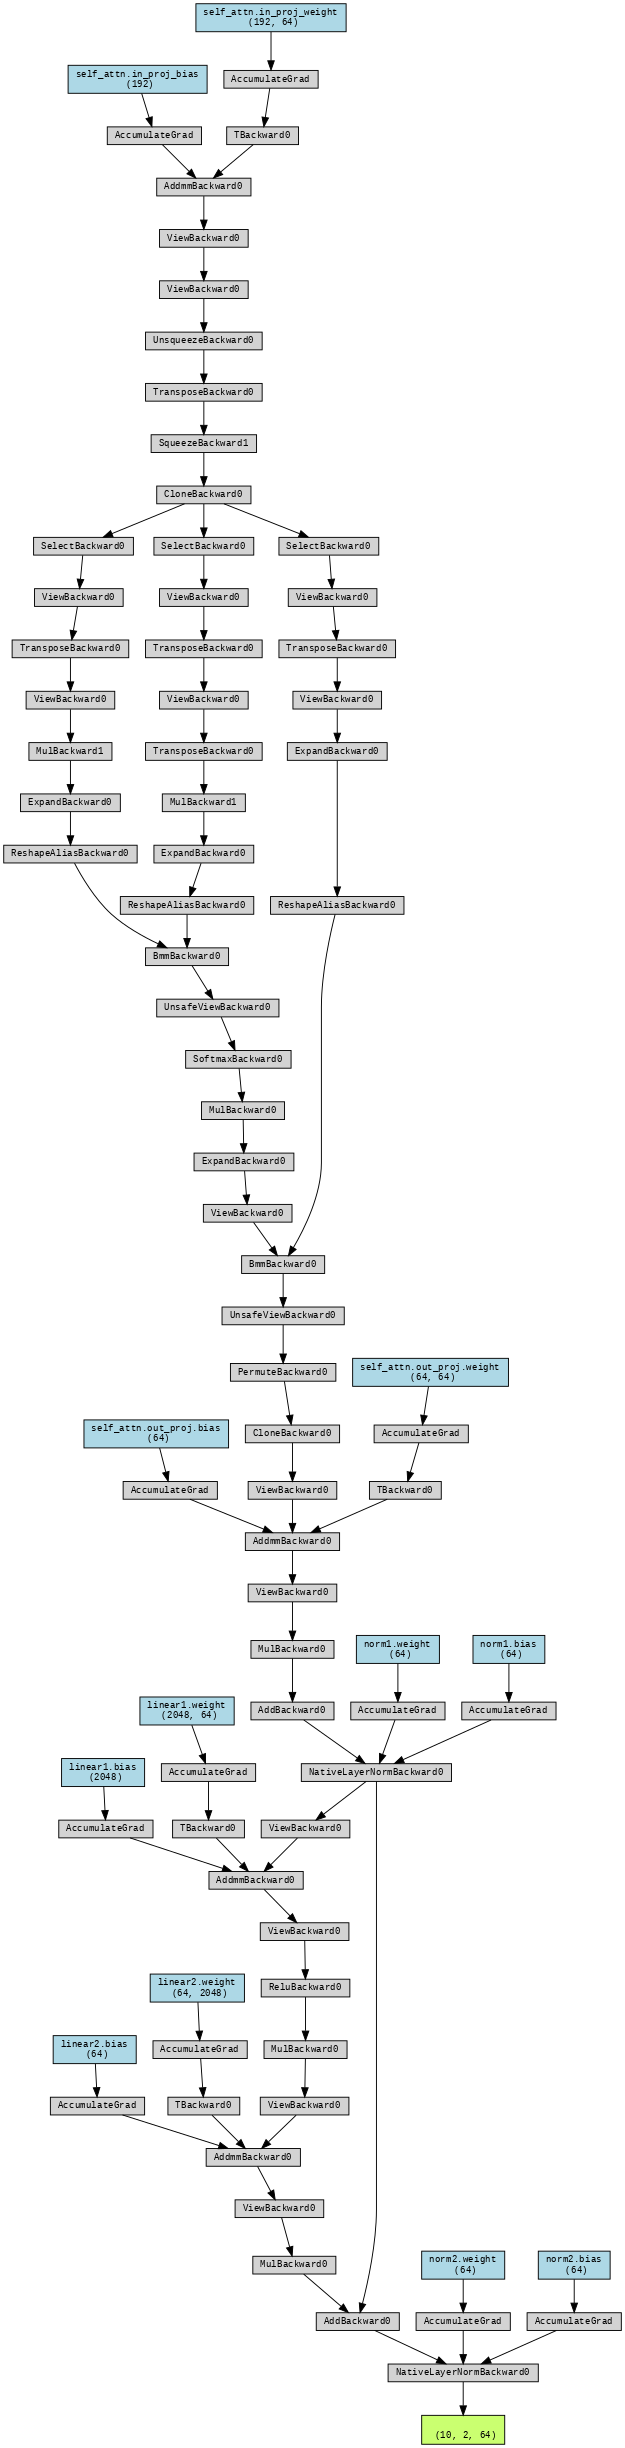

In [12]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define parameters
embedding_dim = 64
num_heads = 4

encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)

src = torch.rand(10, 2, embedding_dim)  # (sequence_length, batch_size, embedding_dim)

output = encoder_layer(src)

graph = make_dot(output, params=dict(encoder_layer.named_parameters()))
graph.render("transformer_encoder_layer_graph", format="png")
